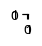

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.models import *
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
from src.torch_utils import save_checkpoint, load_checkpoint
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
mpl.rcParams['figure.dpi'] = 180

In [3]:
from src.models import * 
std = StandardizerSequence()
nnmodel = NNAlignEF(50, 5, n_extrafeatures=5)
df = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,...,icore_improves_binder_0_75,mixed_input_binder_0_75,mixed_rank_binder_0_75,icore_improves_1,mixed_input_1,mixed_rank_1,icore_improves_binder_1,mixed_input_binder_1,mixed_rank_binder_1,expanded_input
0,0,0,0,HLA-B0702,0,6,AAAAAAQQIQV,AAAAAAQQLQV,AAAAAAQQI,AAAAAAQQI,...,False,AAAAAAQQIQV,26.7692,True,AAAAAAQQI,3.9712,False,AAAAAAQQIQV,26.7692,AAAAAAQQI
1,1,1,1,HLA-B0702,0,6,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQIQV,...,False,AAAAQQIQV,4.9092,False,AAAAQQIQV,4.9092,False,AAAAQQIQV,4.9092,AAAAQQIQV
2,2,2,2,HLA-A0201,0,6,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQIQV,...,False,AAAAQQIQV,1.9555,False,AAAAQQIQV,1.9555,False,AAAAQQIQV,1.9555,AAAAQQIQV
3,3,3,3,HLA-A1101,0,9,AAHFTVLLY,AAHFTALLY,AAHFTVLLY,AAHFTVLLY,...,False,AAHFTVLLY,0.4196,False,AAHFTVLLY,0.4196,False,AAHFTVLLY,0.4196,AAHFTVLLY
4,4,4,4,HLA-C1203,0,6,AAIAASRSV,AAIAASRSA,AAIAASRSV,AAIAASRSV,...,False,AAIAASRSV,0.0591,False,AAIAASRSV,0.0591,False,AAIAASRSV,0.0591,AAIAASRSV


In [7]:
loader, dataset = get_NNAlign_dataloader(df, max_len=12, window_size=5, seq_col='Peptide', target_col='agg_label', return_dataset=True, feature_cols = ['EL_rank_mut','EL_rank_wt_aligned','trueHLA_EL_rank'])

In [11]:
x_feats = dataset.x_features
x_tensor = dataset.x_tensor

In [14]:
x_repeat = x_feats.unsqueeze(1).repeat(1, x_tensor.shape[1], 1)

# Concatenate x_tensor and x_feats along dimension 2
concatenated_tensor = torch.cat((x_tensor, x_repeat), dim=2)


In [24]:
from src.data_processing import encode_batch
x_test = encode_batch(df['Peptide'], 12, 'BL50LO', -15)
x_test.flatten(start_dim=1).shape

torch.Size([3033, 240])

## test with pseudoseqs

### quick fix with pseudo seqs with Xs

In [69]:
from src.data_processing import AA_KEYS, BL50_VALUES
# Easy fix for the X's
sequence = 'XXYHWTSGGQTGHGWALGSNYYDIRTETVHGVHT'
size = len(sequence)
blosum_matrix = BL50_VALUES
tmp = np.zeros([size, len(AA_KEYS)], dtype=np.float32)
for idx in range(size):
    # Here, the way Morten takes cares of Xs is to leave it blank, i.e. as zeros
    # So only use blosum matrix to encode if sequence[idx] != 'X'
    if sequence[idx]!='X':
        tmp[idx, :] = blosum_matrix[sequence[idx]]
    

### try repeat

In [70]:
from src.data_processing import AA_KEYS
ps = pd.read_csv('../data/pseudoseqs/pseudosequence.2016.all.X.dat', sep='\t', header=None, names=['hla', 'seq'])
ps['flag'] = ps['seq'].apply(lambda x: any([c not in AA_KEYS for c in x]))
ps.query('flag')
ps.head()

,hla,seq,flag
0,DRB1_0101,QEFFIASGAAVDAIMWLFLECYDLQRATYHVGFT,False
1,DRB1_0102,QEFFIASGAAVDAIMWLFLECYDLQRATYHAVFT,False
2,DRB1_0103,QEFFIASGAAVDAIMWLFLECYDIDEATYHVGFT,False
3,DRB1_0104,QEFFIASGAAVDAIMWLFLECYDLQRANYHVVFT,False
4,DRB1_0105,QEFFIASGAAVDAIMWLFLECYDLQRATYHVGFT,False


In [71]:
ps.query('flag')['seq'].iloc[0]

'XXYHWTSGGQTGHGWALGSNYYDIRTETVHGVHT'

In [72]:
# This would be the x_pseudoseq in the dataset class
x_ps = encode_batch(ps.query('not flag')['seq'], max_len=34, encoding='BL50LO', pad_scale=None)
# here take len(x_tensor) just for a check
x_ps_repeat = x_ps.flatten(start_dim=1).unsqueeze(1).repeat(1, x_tensor.shape[1], 1)[:len(x_tensor)]
torch.cat([x_tensor, x_ps_repeat], dim=2).shape

torch.Size([3033, 8, 780])